In [95]:
import numpy as np
import pandas as pd
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Data

In [96]:
# variable names key
key = pd.read_csv('data/VariableLookup.csv')
print(key.shape)
key.head()

(83, 3)


,Field,LongName,Description
0,CensusTract,Census tract,Census tract number
1,State,State,State name
2,County,County,County name
3,Urban,Urban tract,Flag for urban tract
4,POP2010,"Population, tract total",Population count from 2010 census


In [98]:
# full dataset
df = pd.read_csv('data/USDA_ERS_data.csv')

In [99]:
# rename hispanic columns for compatibility
df = df.rename(columns = {'lahisp1':'lahispanic1', 
                          'lahisp1share':'lahispanic1share', 
                          'lahisp10':'lahispanic10', 
                          'lahisp10share':'lahispanic10share'})
df.columns

Index(['CensusTract', 'State', 'County', 'Urban', 'Pop2010', 'OHU2010',
       'GroupQuartersFlag', 'NUMGQTRS', 'PCTGQTRS', 'LILATracts_1And10',
       'HUNVFlag', 'LowIncomeTracts', 'PovertyRate', 'MedianFamilyIncome',
       'LA1and10', 'LATracts1', 'LATracts10', 'LAPOP1_10', 'LALOWI1_10',
       'lapop1', 'lapop1share', 'lalowi1', 'lalowi1share', 'lakids1',
       'lakids1share', 'laseniors1', 'laseniors1share', 'lawhite1',
       'lawhite1share', 'lablack1', 'lablack1share', 'laasian1',
       'laasian1share', 'lanhopi1', 'lanhopi1share', 'laaian1', 'laaian1share',
       'laomultir1', 'laomultir1share', 'lahispanic1', 'lahispanic1share',
       'lahunv1', 'lahunv1share', 'lasnap1', 'lasnap1share', 'lapop10',
       'lapop10share', 'lalowi10', 'lalowi10share', 'lakids10',
       'lakids10share', 'laseniors10', 'laseniors10share', 'lawhite10',
       'lawhite10share', 'lablack10', 'lablack10share', 'laasian10',
       'laasian10share', 'lanhopi10', 'lanhopi10share', 'laaian10',
    

In [100]:
# adding column for adults (age 18-64)
df['laadults1'] = df['lapop1'] - df['lakids1'] - df['laseniors1']
df['laadults10'] = df['lapop10'] - df['lakids10'] - df['laseniors10']
df['TractAdults'] = df['Pop2010'] - df['TractKids'] - df['TractSeniors']
print(df.shape)
df.head()

(72531, 86)


,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,laadults1,laadults10,TractAdults
0,1001020100,Alabama,Autauga County,1,1912,693,0,0.0,0.00,0,...,14.0,0.0,14.0,45.0,44.0,6.0,102.0,1173.0,NaN,1184.0
1,1001020200,Alabama,Autauga County,1,2170,743,0,181.0,8.34,1,...,5.0,0.0,5.0,55.0,75.0,89.0,156.0,728.0,NaN,1350.0
2,1001020300,Alabama,Autauga County,1,3373,1256,0,0.0,0.00,0,...,17.0,5.0,11.0,117.0,87.0,99.0,172.0,935.0,NaN,2040.0
3,1001020400,Alabama,Autauga County,1,4386,1722,0,0.0,0.00,0,...,18.0,4.0,11.0,74.0,85.0,21.0,98.0,780.0,NaN,2467.0
4,1001020500,Alabama,Autauga County,1,10766,4082,0,181.0,1.68,0,...,296.0,9.0,48.0,310.0,355.0,230.0,339.0,1566.0,NaN,6478.0


# Total Population

In [101]:
# makes a table given data values and columns
def make_table(values, columns):
    table = plt.table(cellText = values,
                  colLabels = columns,
                  loc='center', 
                  cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.auto_set_column_width((0))
    # bold column headings
    for (row, col), cell in table.get_celld().items():
        if (row == 0):
            cell.set_text_props(fontproperties=FontProperties(weight='bold', size=7))
    plt.axis('off')

In [102]:
# finding totals and proportions for low access to supermarkets
status = ['LAPOP', 'LALOWI']
total_pop = np.array([])

# initializing arrays
total_insecure_1mi = np.array([])
prop_insecure_1mi = np.array([])

total_insecure_10mi = np.array([])
prop_insecure_10mi = np.array([])

total_insecure_1mi_10mi = np.array([])
prop_insecure_1mi_10mi = np.array([])

for s in status:
    # column names
    la_1mi = s.lower() + '1'
    la_10mi = s.lower() + '10'
    la_110mi = s + '1_10'
    # total population and number insecure
    total = df['Pop2010'].sum()
    total_pop = np.append(total_pop, total)
    # appending to 1 mile arrays
    insecure1 = df[la_1mi].sum()
    total_insecure_1mi = np.append(total_insecure_1mi, insecure1)
    prop_insecure_1mi = np.append(prop_insecure_1mi, insecure1/total * 100)
    # appending to 10 mile arrays
    insecure10 = df[la_10mi].sum()
    total_insecure_10mi = np.append(total_insecure_10mi, insecure10)
    prop_insecure_10mi = np.append(prop_insecure_10mi, insecure10/total * 100)
    # appending to 1 mile and 10 mile arrays
    insecure110 = df[la_110mi].sum()
    total_insecure_1mi_10mi = np.append(total_insecure_1mi_10mi, insecure110)
    prop_insecure_1mi_10mi = np.append(prop_insecure_1mi_10mi, insecure110/total * 100)

In [103]:
# creates dataframe of totals 
status_total_df = pd.DataFrame({'Total': total_pop,
                                 '1mi+': np.round(total_insecure_1mi, 2),
                                 '10mi+': np.round(total_insecure_10mi, 2),
                                 '1mi+ (urban), 10mi+ (rural)': np.round(total_insecure_1mi_10mi, 2)},
                                 index=['Low Access (Number of People)', 'Low Access and Income (Number)'])
# formatting large numbers
status_total_df['Total'] = status_total_df.apply(lambda x: "{:,.0f}".format(x['Total']), axis=1)
status_total_df['1mi+'] = status_total_df.apply(lambda x: "{:,.0f}".format(x['1mi+']), axis=1)
status_total_df['10mi+'] = status_total_df.apply(lambda x: "{:,.0f}".format(x['10mi+']), axis=1)
status_total_df['1mi+ (urban), 10mi+ (rural)'] = status_total_df.apply(lambda x: "{:,.0f}".format(x['1mi+ (urban), 10mi+ (rural)']), axis=1)
status_total_df = status_total_df.T.reset_index().rename(columns={'index':'Distance from Supermarket'})
status_total_df

,Distance from Supermarket,Low Access (Number of People),Low Access and Income (Number)
0,Total,"308,745,538","308,745,538"
1,1mi+,"122,826,152","35,187,961"
2,10mi+,"5,144,697","1,940,796"
3,"1mi+ (urban), 10mi+ (rural)","68,611,398","18,834,033"


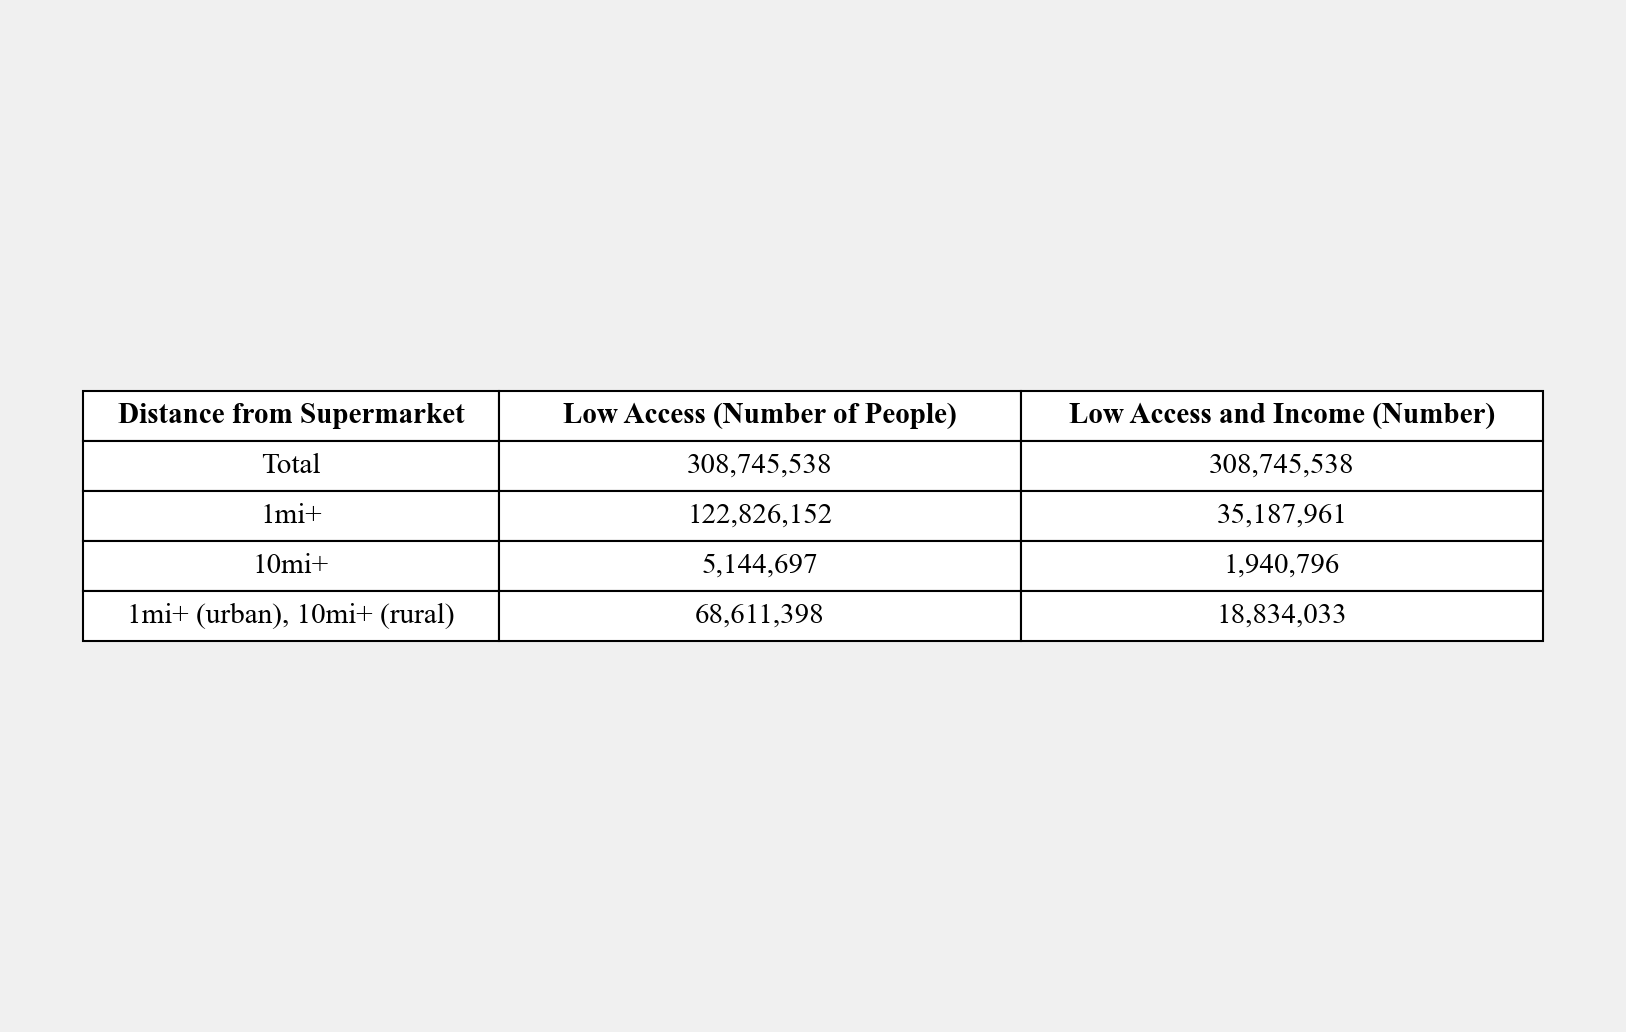

In [104]:
# creates table from above dataframe
status_total_table = make_table(status_total_df.values, status_total_df.columns)

# saves figure as png
plt.savefig('figures/demography/status-total-table.png', bbox_inches = 'tight', transparent = True)
plt.show()

In [105]:
# creates dataframe of proportions
status_percentage_df = pd.DataFrame({'1mi+': np.round(prop_insecure_1mi, 2),
                                     '10mi+': np.round(prop_insecure_10mi, 2),
                                     '1mi+ (urban), 10mi+ (rural)': np.round(prop_insecure_1mi_10mi, 2)},
                                     index=['Low Access (Percentage of People)', 'Low Access & Income (Percentage)'])
# takes transpose
status_percentage_df = status_percentage_df.T.reset_index().rename(columns={'index':'Distance from Supermarket'})
status_percentage_df

,Distance from Supermarket,Low Access (Percentage of People),Low Access & Income (Percentage)
0,1mi+,39.78,11.40
1,10mi+,1.67,0.63
2,"1mi+ (urban), 10mi+ (rural)",22.22,6.10


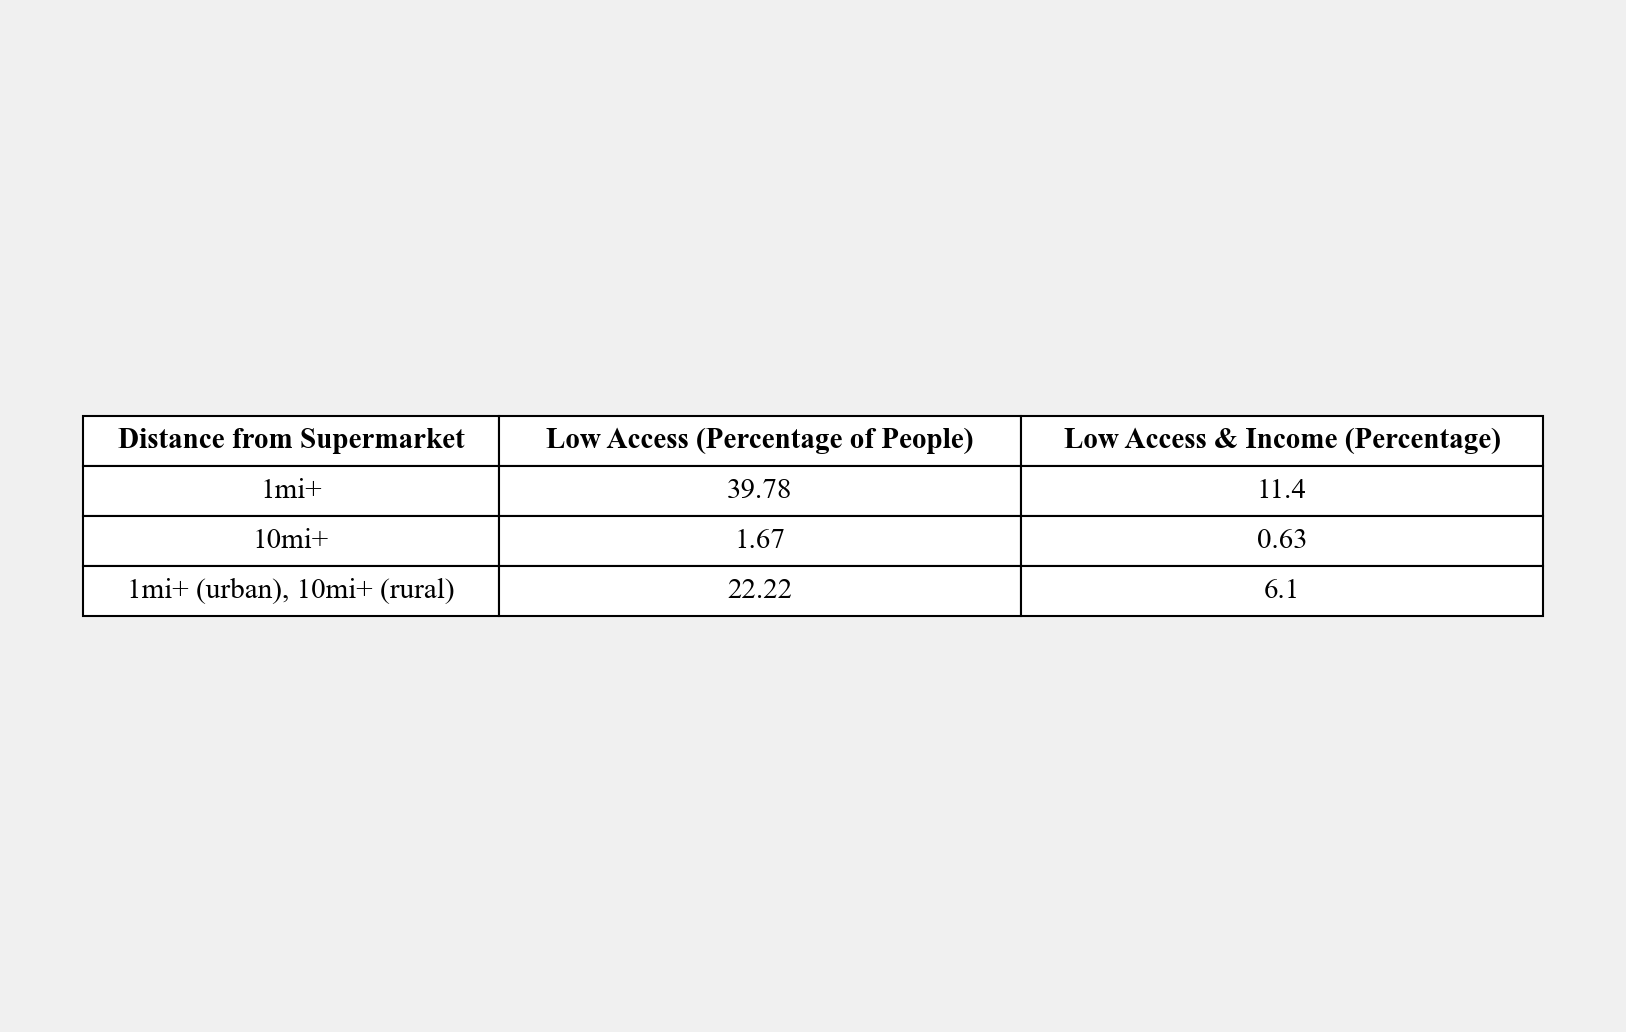

In [106]:
# creates table from above dataframe
status_percentage_table = make_table(status_percentage_df.values, status_percentage_df.columns)

# saves figure as png
plt.savefig('figures/demography/status-percentage-table.png', bbox_inches = 'tight', transparent = True)
plt.show()

# Urban and Rural

In [107]:
# groups df by urban and rural markers
ur_df = df.groupby(by='Urban').sum().reset_index()
ur_df

,Urban,CensusTract,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,HUNVFlag,LowIncomeTracts,...,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,laadults1,laadults10,TractAdults
0,0,522032747288040,70971304,26928947,73,1712839.0,39157.10,1352,3076,5810,...,719217.0,66695.0,1156014.0,3169330.0,5024623.0,1205513.0,3017116.0,36618645.0,3046314.0,43605687.0
1,1,1496194926102625,237774234,89787345,443,6271634.0,157238.27,7941,12215,24477,...,13955003.0,473316.0,1756113.0,24946824.0,45452666.0,9217323.0,11615437.0,39495138.0,64022.0,150679001.0


In [108]:
# creates dataframe of totals and proportions
total = ur_df['Pop2010'].sum()
ur_insecure_df = pd.DataFrame({'Total, #': ur_df['Pop2010'].values,
                               '1-10 Miles, #': ur_df['lapop1'].values-ur_df['lapop10'].values,
                               '10+ Miles, #': ur_df['lapop10'].values,
                               'Total, %': np.round(ur_df['Pop2010'].values*100/total, 2),
                               '1-10 Miles, %': np.round((ur_df['lapop1'].values-ur_df['lapop10'].values)*100/total, 2),
                               '10+ Miles, %': np.round(ur_df['lapop10'].values*100/total, 2)},
                             index = ['Rural', 'Urban'])
ur_insecure_df

,"Total, #","1-10 Miles, #","10+ Miles, #","Total, %","1-10 Miles, %","10+ Miles, %"
Rural,70971304,54208513.0,5042687.0,22.99,17.56,1.63
Urban,237774234,63472942.0,102010.0,77.01,20.56,0.03


<ipython-input-109-7def64420965>:24: UserWarning: The handle <matplotlib.patches.Wedge object at 0x7f840f32dca0> has a label of '_Urban' which cannot be automatically added to the legend.
  ax.legend(subgroup_names, fontsize = 10, loc=(0.15, -0.25), ncol=2,
<ipython-input-109-7def64420965>:24: UserWarning: The handle <matplotlib.patches.Wedge object at 0x7f84130e1310> has a label of '_Rural' which cannot be automatically added to the legend.
  ax.legend(subgroup_names, fontsize = 10, loc=(0.15, -0.25), ncol=2,


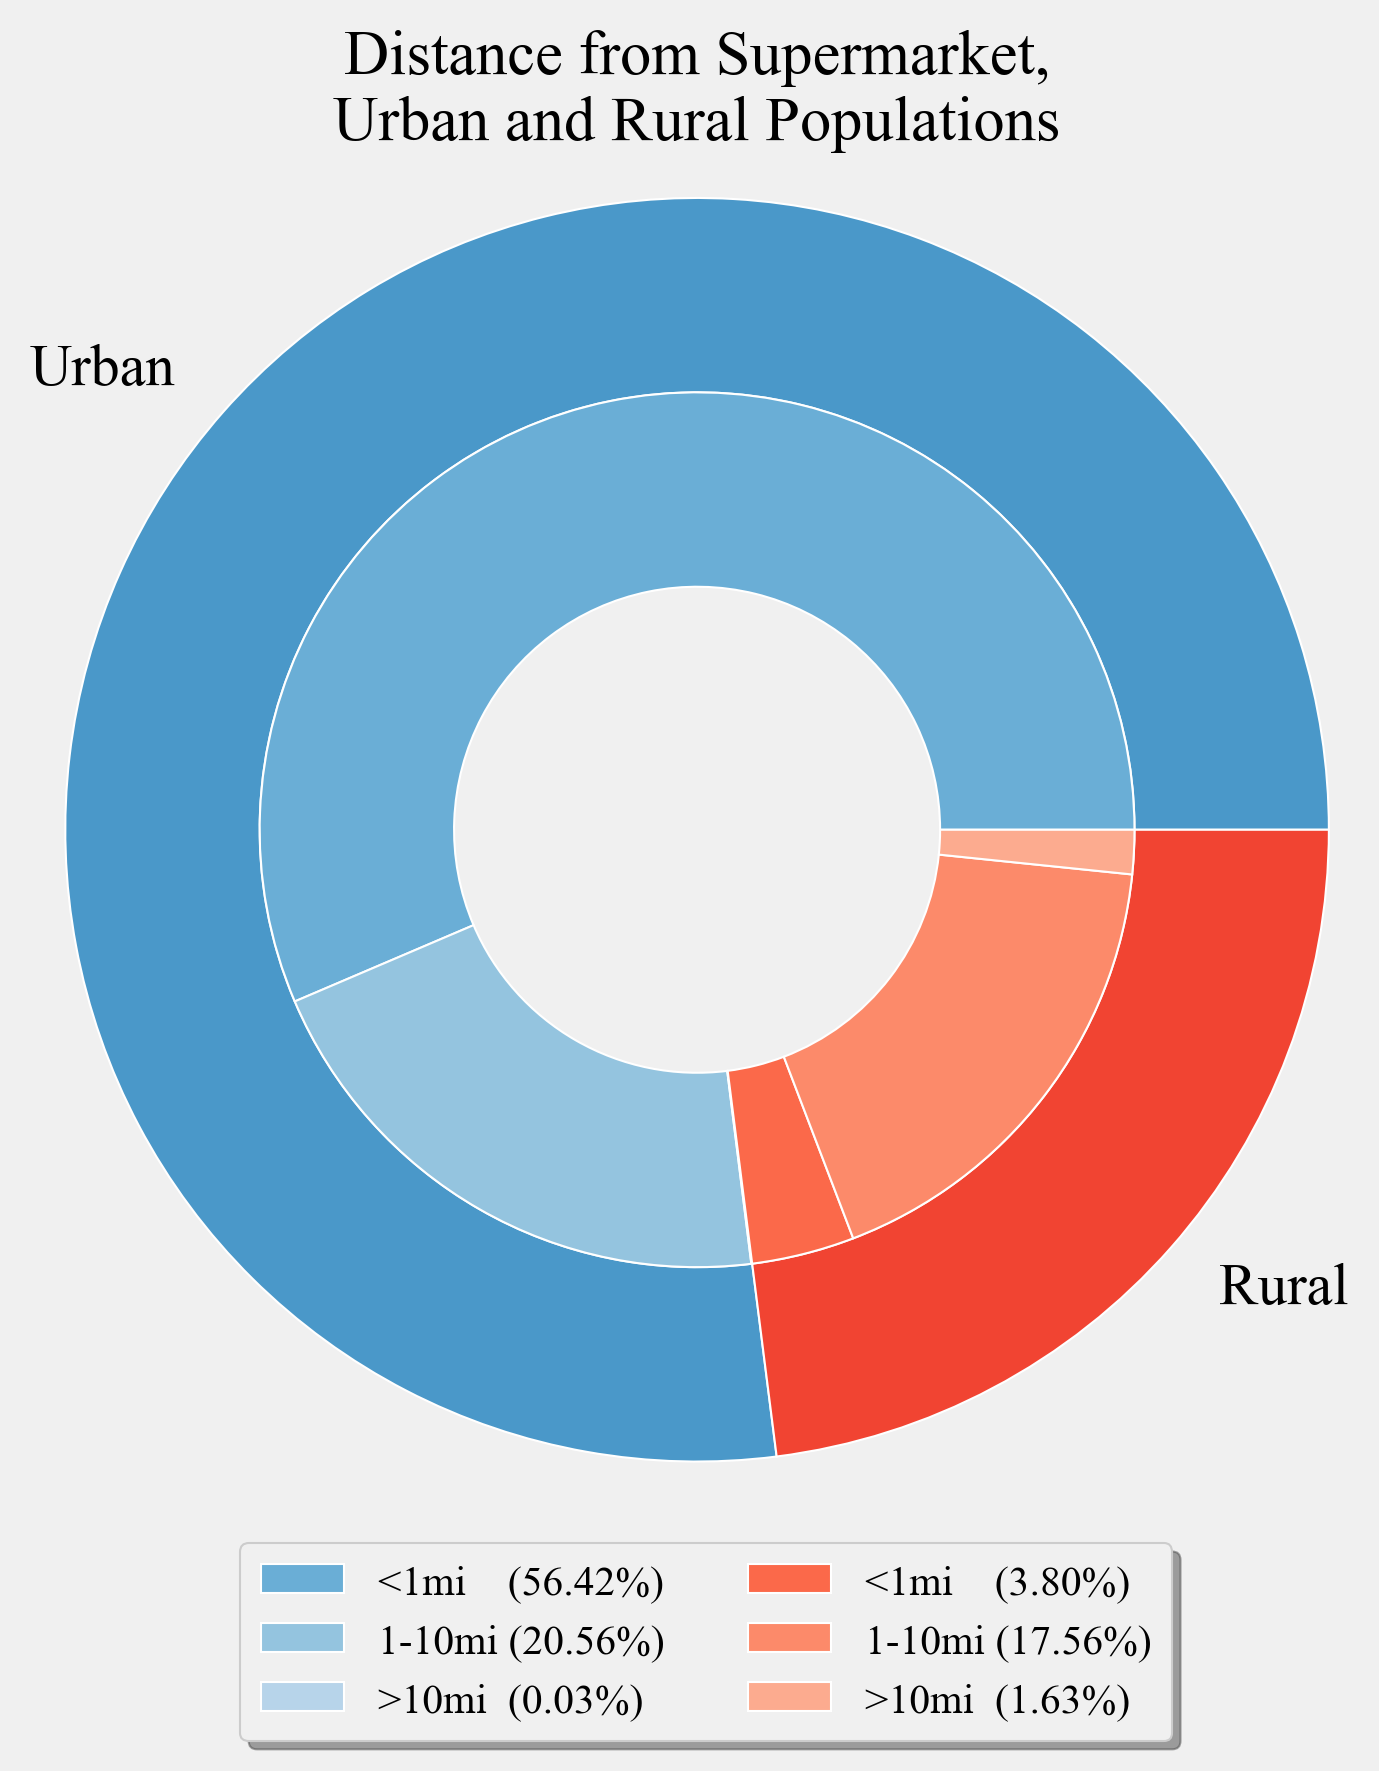

In [109]:
# creates pie chart from above dataframe

# make data
group_names=['Urban', 'Rural']
group_size=[77.01, 22.99]
subgroup_names=['_Urban', '_Rural', '<1mi    (56.42%)', '1-10mi (20.56%)', '>10mi  (0.03%)',
                '<1mi    (3.80%)', '1-10mi (17.56%)', '>10mi  (1.63%)']
subgroup_size=[56.42,20.56,0.03,3.8,17.56,1.63]

# create colors
a, b = [plt.cm.Blues, plt.cm.Reds]

fig, ax = plt.subplots()
ax.axis('equal')
# first ring (outside)
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors= [a(0.6), b(0.6)] )
plt.setp( mypie, width=0.4, edgecolor='white')

# second ring (inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.4, colors=[a(0.5), a(0.4), a(0.3), b(0.5), b(0.4), b(0.3)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

ax.legend(subgroup_names, fontsize = 10, loc=(0.15, -0.25), ncol=2, 
          fancybox=True, framealpha=1, shadow=True, borderpad=0.5)

ax.set(aspect="equal")
ax.set_title('Distance from Supermarket,\nUrban and Rural Populations', size = 15, pad = 20)
fig.set_size_inches(5, 5)

# saves figure as png
plt.savefig('figures/demography/ur-pie.png', bbox_inches = 'tight', transparent = True)
plt.show()

In [110]:
# creates dataframe of total tracts
total_tracts = np.array([72531 - df['Urban'].sum(), df['Urban'].sum()])
ur_number_df = pd.DataFrame({'Total': total_tracts,
                             'Low Access': ur_df['LA1and10'].values,
                             'Low Income': ur_df['LowIncomeTracts'].values,
                             'Low Access and Income': ur_df['LILATracts_1And10'].values},
                            index = ['Rural (Number of Tracts)', 'Urban (Number)'])

# formatting large numbers
ur_number_df['Total'] = ur_number_df.apply(lambda x: "{:,.0f}".format(x['Total']), axis=1)
ur_number_df['Low Access'] = ur_number_df.apply(lambda x: "{:,.0f}".format(x['Low Access']), axis=1)
ur_number_df['Low Income'] = ur_number_df.apply(lambda x: "{:,.0f}".format(x['Low Income']), axis=1)
ur_number_df['Low Access and Income'] = ur_number_df.apply(lambda x: "{:,.0f}".format(x['Low Access and Income']), axis=1)
ur_number_df = ur_number_df.T.reset_index().rename(columns={'index':'Status'})
ur_number_df

,Status,Rural (Number of Tracts),Urban (Number)
0,Total,"17,362","55,169"
1,Low Access,"3,186","24,362"
2,Low Income,"5,810","24,477"
3,Low Access and Income,"1,352","7,941"


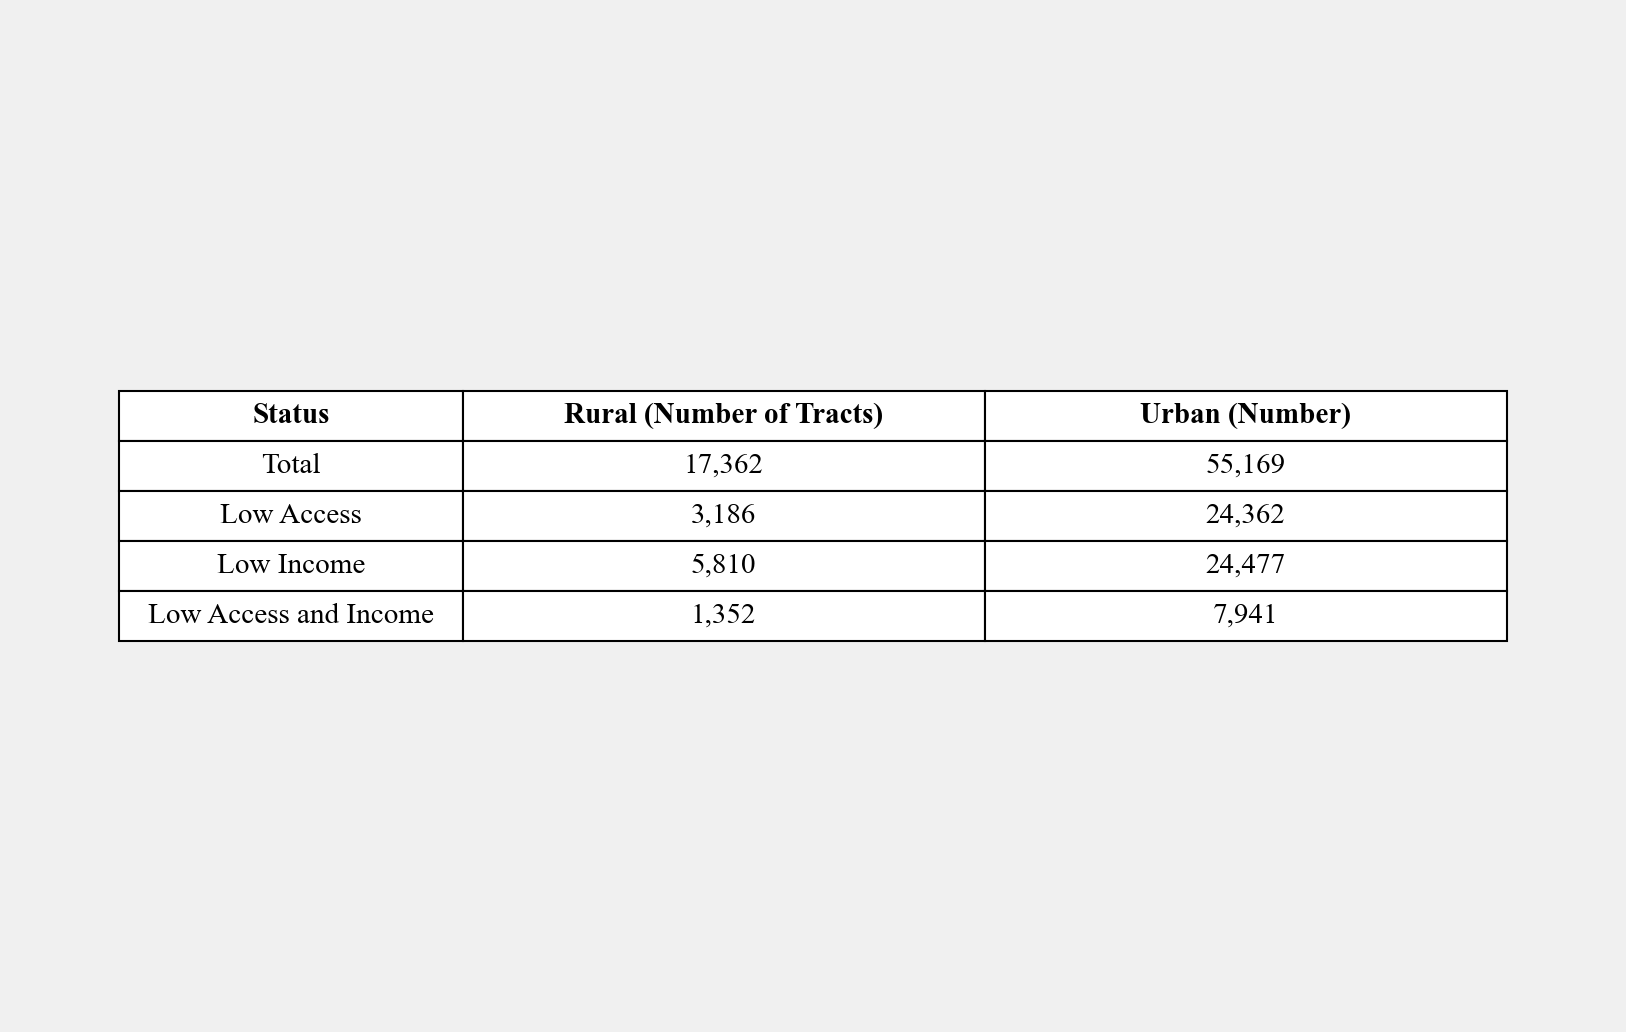

In [111]:
# creates table from above dataframe
ur_total_table = make_table(ur_number_df.values, ur_number_df.columns)

# saves figure as png
plt.savefig('figures/demography/ur-total-table.png', bbox_inches = 'tight', transparent = True)
plt.show()

In [112]:
# creates dataframe of proportion tracts
total_tracts = np.array([72531 - df['Urban'].sum(), df['Urban'].sum()])
ur_percentage_df = pd.DataFrame({'Low Access': np.round(ur_df['LA1and10'].values*100/total_tracts, 2),
                                 'Low Income': np.round(ur_df['LowIncomeTracts'].values*100/total_tracts, 2),
                                 'Low Access and Income': np.round(ur_df['LILATracts_1And10'].values*100/total_tracts, 2)},
                            index = ['Rural (Percentage of Tracts)', 'Urban (Percentage)'])
# takes transpose
ur_percentage_df = ur_percentage_df.T.reset_index().rename(columns={'index':'Status'})
ur_percentage_df

,Status,Rural (Percentage of Tracts),Urban (Percentage)
0,Low Access,18.35,44.16
1,Low Income,33.46,44.37
2,Low Access and Income,7.79,14.39


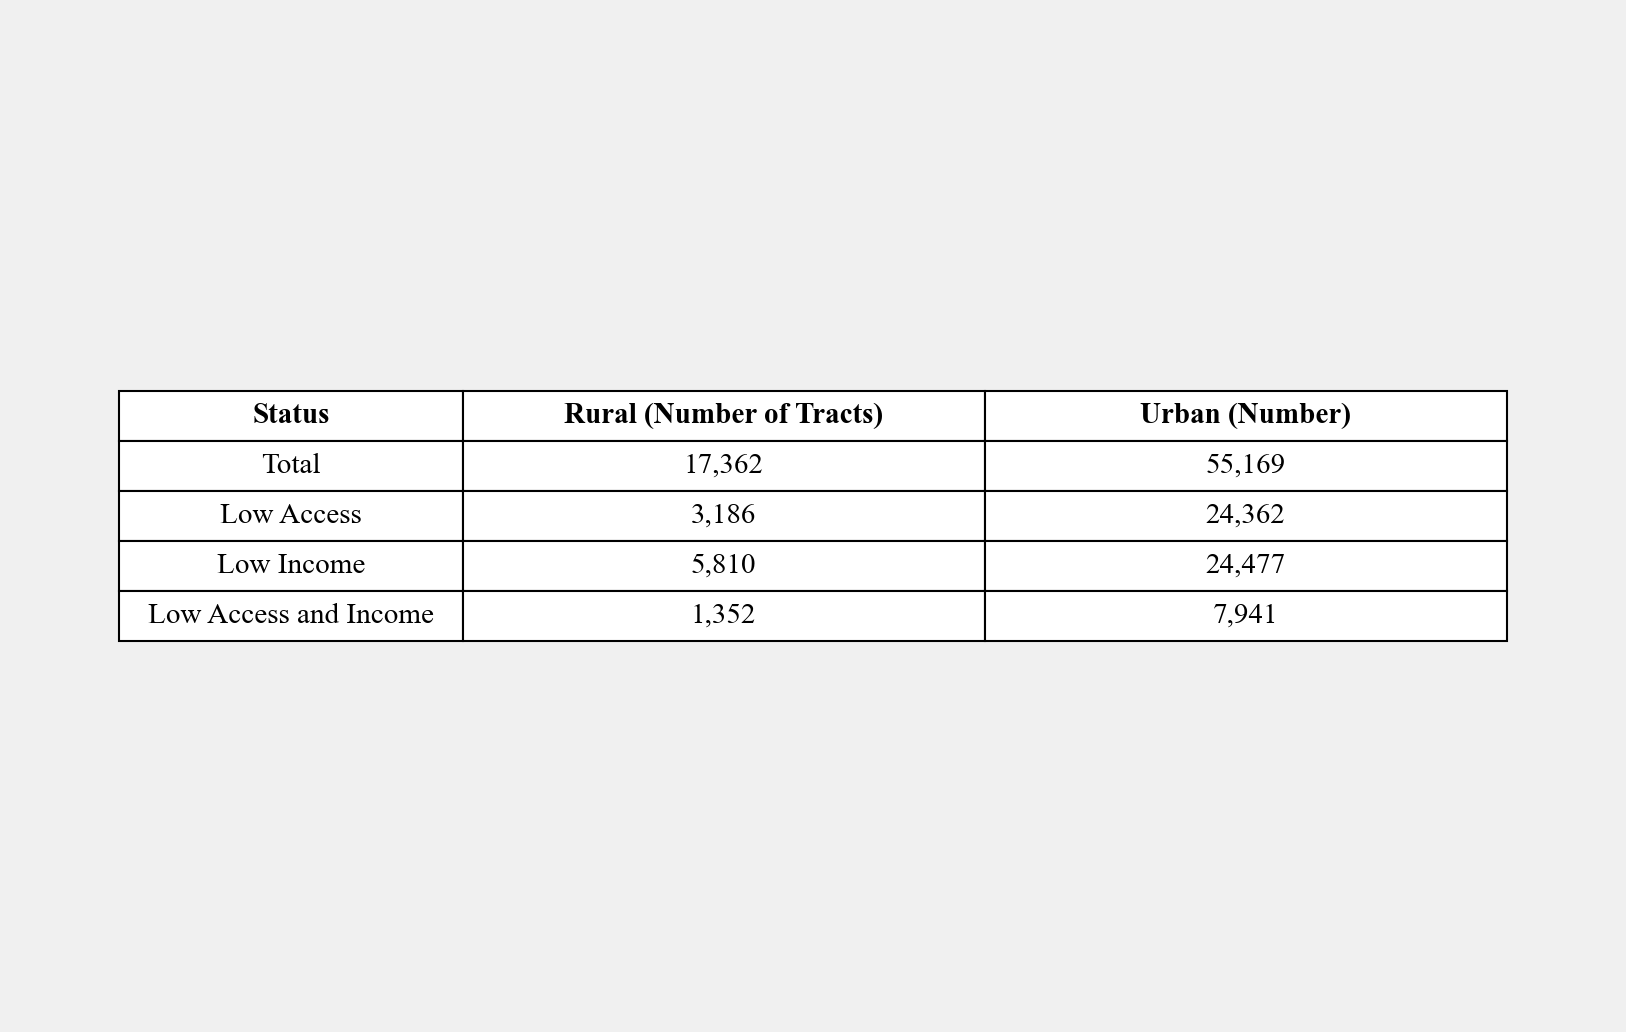

In [113]:
# creates table from above dataframe
ur_percentage_table = make_table(ur_number_df.values, ur_number_df.columns)

# saves figure as png
plt.savefig('figures/demography/ur-percentage-table.png', bbox_inches = 'tight', transparent = True)
plt.show()

# Race

In [114]:
# makes a double bar chart given data values and labels
def make_double_bar(bars1, bars2, labels):
    x = np.arange(len(labels))  # label locations
    width = 0.35  # width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.barh(x + width/2, bars1, width, label='1+ mi')
    rects2 = ax.barh(x - width/2, bars2, width, label='10+ mi', color = 'DarkBlue')
    # add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Percentage', size = 15)
    ax.set_title('Percentage Living 1mi+ and 10mi+ from Supermarket, by Race', size = 20)
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.legend(fontsize = 15, fancybox=True, framealpha=1, shadow=True, borderpad=0.5)
    # bar labels
    ax.bar_label(rects1, padding=3, size = 15)
    ax.bar_label(rects2, padding=3, size = 15)
    fig.tight_layout()
    fig.set_size_inches(10, 7)

In [115]:
# finding totals and proportions for low access to supermarkets based on race
races = ['White', 'Black', 'Hispanic', 'Asian', 'NHOPI', 'AIAN', 'OMultir']
total_pop_race = np.array([])

# initializing arrays
total_insecure_race_1mi = np.array([])
prop_insecure_race_1mi = np.array([])

total_insecure_race_10mi = np.array([])
prop_insecure_race_10mi = np.array([])

for r in races:
    # column names
    tract_race = 'Tract' + r
    la_race_1mi = 'la' + r.lower() + '1'
    la_race_10mi = 'la' + r.lower() + '10'
    # total population and number insecure
    total = df[tract_race].sum()
    total_pop_race = np.append(total_pop_race, total)
    # appending to 1 mile arrays
    insecure1 = df[la_race_1mi].sum()
    total_insecure_race_1mi = np.append(total_insecure_race_1mi, insecure1)
    prop_insecure_race_1mi = np.append(prop_insecure_race_1mi, insecure1/total * 100)
    # appending to 10 mile arrays
    insecure10 = df[la_race_10mi].sum()
    total_insecure_race_10mi = np.append(total_insecure_race_10mi, insecure10)
    prop_insecure_race_10mi = np.append(prop_insecure_race_10mi, insecure10/total * 100)

In [116]:
# creates dataframe of totals and proportions
race_df = pd.DataFrame({'Race':['White', 'Black', 'Hispanic', 'Asian', 'Pacific Islander', 'Native American', 'Other/Multiracial'], 
                        'Total': total_pop_race,
                        '1+ Miles, #': np.round(total_insecure_race_1mi, 2),
                        '10+ Miles, #': np.round(total_insecure_race_10mi, 2),
                        '1+ Miles, %': np.round(prop_insecure_race_1mi, 2),
                        '10+ Miles, %': np.round(prop_insecure_race_10mi, 2),})
race_df = race_df.sort_values(by='1+ Miles, %')
race_df

,Race,Total,"1+ Miles, #","10+ Miles, #","1+ Miles, %","10+ Miles, %"
3,Asian,14674220.0,3042633.0,21768.0,20.73,0.15
2,Hispanic,50477289.0,11341196.0,383358.0,22.47,0.76
6,Other/Multiracial,28116154.0,6630884.0,235243.0,23.58,0.84
4,Pacific Islander,540011.0,151495.0,4052.0,28.05,0.75
1,Black,38929314.0,11478953.0,368505.0,29.49,0.95
0,White,223552667.0,100087798.0,4216564.0,44.77,1.89
5,Native American,2912127.0,1434456.0,298419.0,49.26,10.25


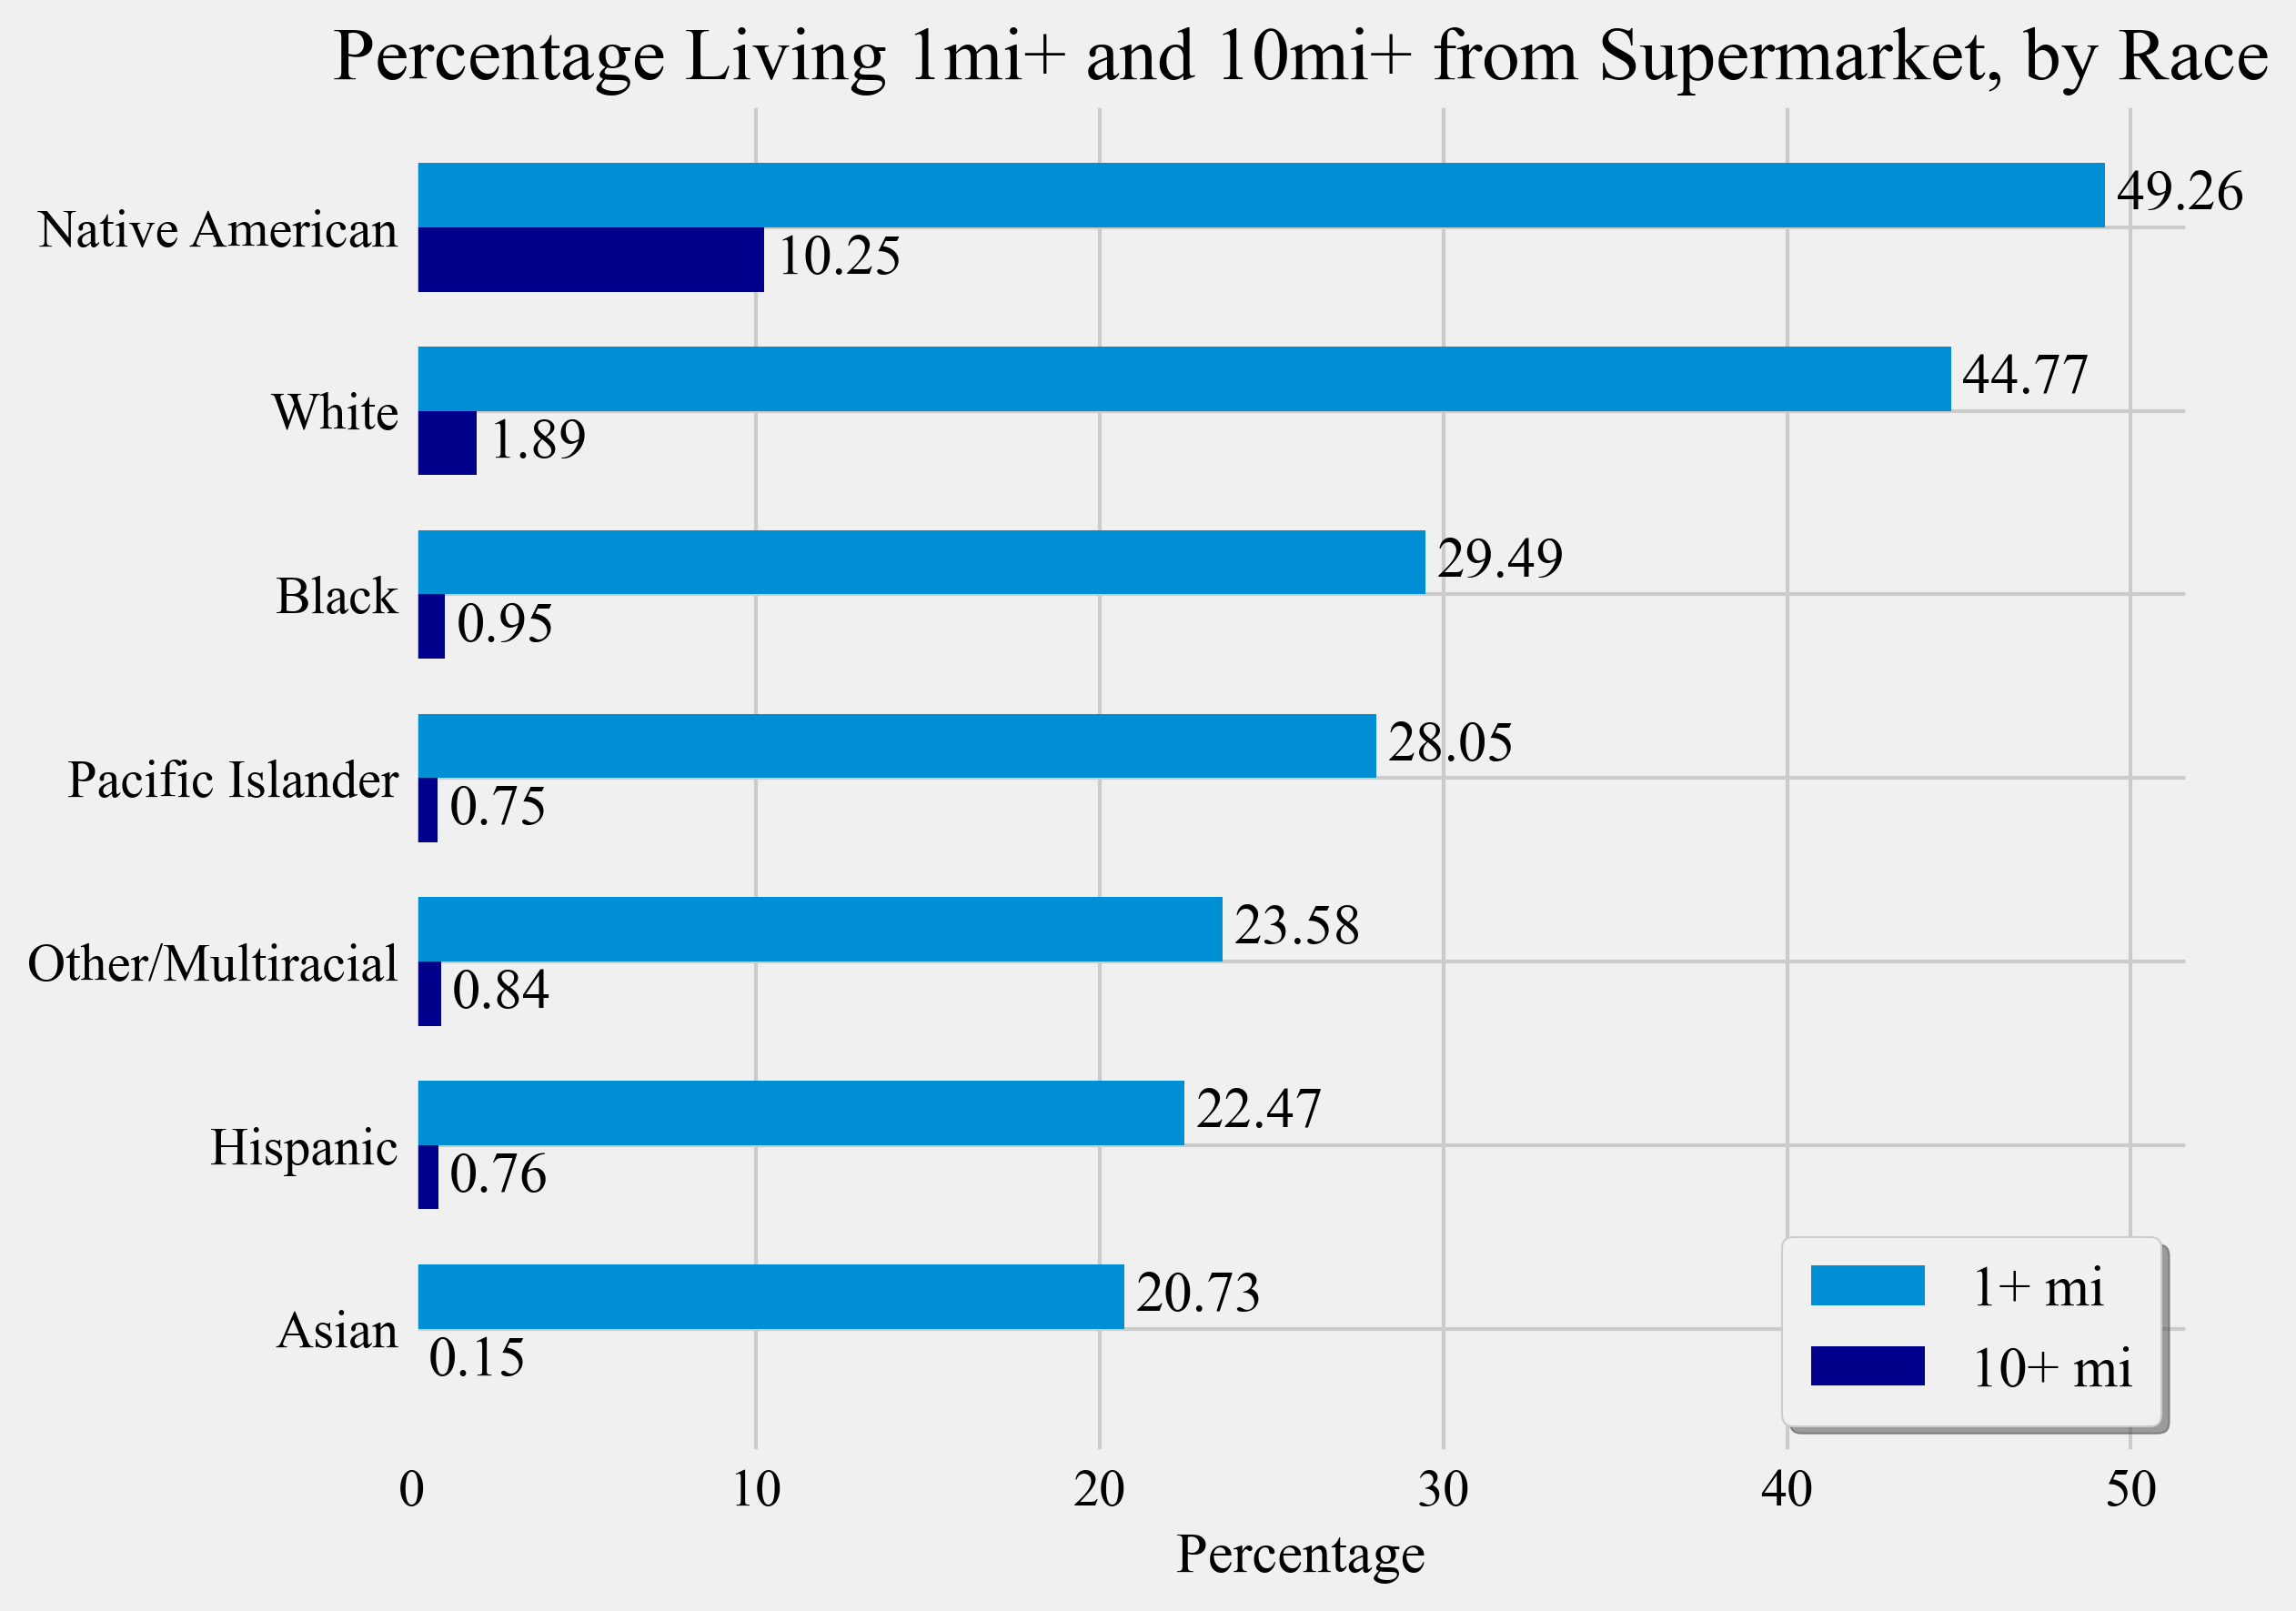

In [117]:
# creates double bar chart from above dataframe proportions
labels = race_df['Race']
onemi = race_df['1+ Miles, %']
tenmi = race_df['10+ Miles, %']

race_bar = make_double_bar(onemi, tenmi, labels)

# saves figure as png
plt.savefig('figures/demography/race-bar.png', bbox_inches = 'tight', transparent = True)
plt.show()

# Age

In [118]:
# finding totals and proportions for low access to supermarkets based on age
ages = ['Kids', 'Adults', 'Seniors']
total_pop_age = np.array([])

# initializing arrays
total_insecure_age_1mi = np.array([])
prop_insecure_age_1mi = np.array([])

total_insecure_age_10mi = np.array([])
prop_insecure_age_10mi = np.array([])

for a in ages:
    # column names
    tract_age = 'Tract' + a
    la_age_1mi = 'la' + a.lower() + '1'
    la_age_10mi = 'la' + a.lower() + '10'
    # total population and number insecure
    total = df[tract_age].sum()
    total_pop_age = np.append(total_pop_age, total)
    # appending to 1 mile arrays
    insecure1 = df[la_age_1mi].sum()
    total_insecure_age_1mi = np.append(total_insecure_age_1mi, insecure1)
    prop_insecure_age_1mi = np.append(prop_insecure_age_1mi, insecure1/total * 100)
    # appending to 10 mile arrays
    insecure10 = df[la_age_10mi].sum()
    total_insecure_age_10mi = np.append(total_insecure_age_10mi, insecure10)
    prop_insecure_age_10mi = np.append(prop_insecure_age_10mi, insecure10/total * 100)

In [119]:
# creates dataframe of totals and proportions
age_df = pd.DataFrame({'Age':['Kids (0-17)', 'Adults (18-64)', 'Seniors (65+)'],
                       'Total': total_pop_age,
                       '1+ Miles, #': np.round(total_insecure_age_1mi, 2),
                       '10+ Miles, #': np.round(total_insecure_age_10mi, 2),
                       '1+ Miles, %': np.round(prop_insecure_age_1mi, 2),
                       '10+ Miles, %': np.round(prop_insecure_age_10mi, 2)})
age_df

,Age,Total,"1+ Miles, #","10+ Miles, #","1+ Miles, %","10+ Miles, %"
0,Kids (0-17),74173024.0,29935778.0,1171148.0,40.36,1.58
1,Adults (18-64),194284688.0,76113783.0,3110336.0,39.18,1.60
2,Seniors (65+),40266781.0,16776591.0,863213.0,41.66,2.14


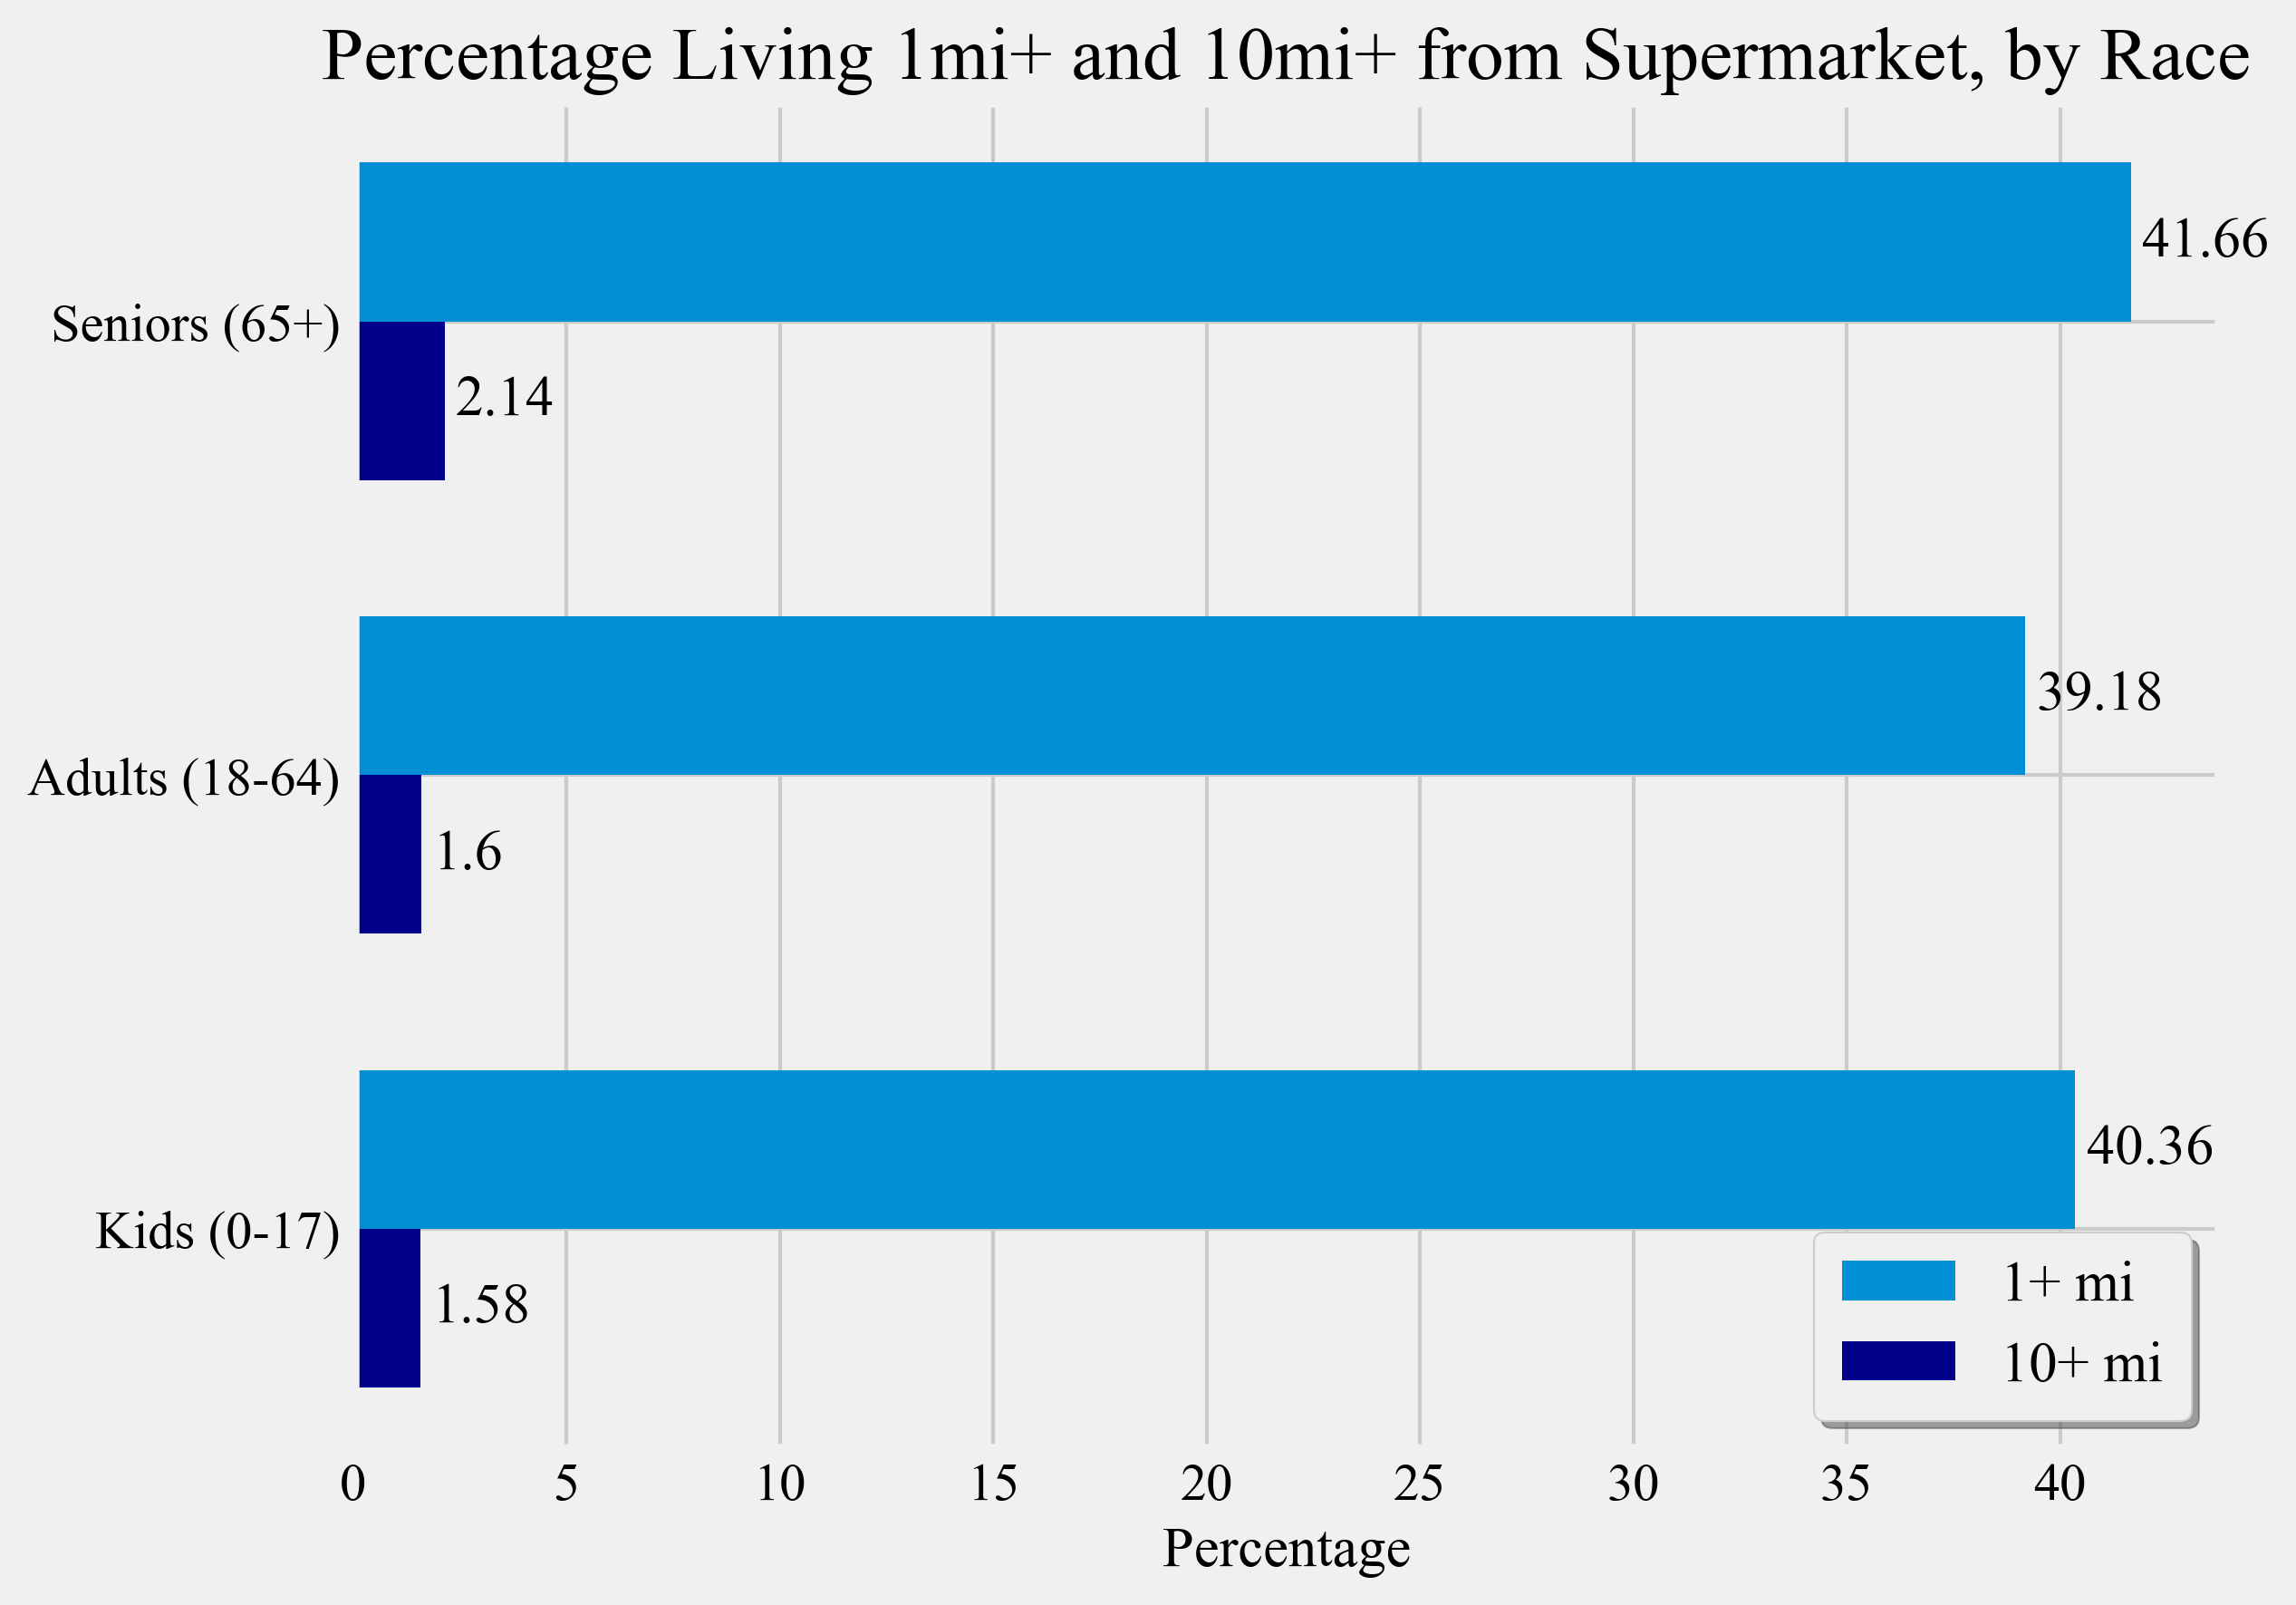

In [120]:
# creates double bar chart from above dataframe proportions
labels = age_df['Age']
onemi = age_df['1+ Miles, %']
tenmi = age_df['10+ Miles, %']

age_bar = make_double_bar(onemi, tenmi, labels)

# saves figure as png
plt.savefig('figures/demography/age-bar.png', bbox_inches = 'tight', transparent = True)
plt.show()